In [ ]:
import os, re, json, cv2, torch, torchvision, sys
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import cv2, torch
import numpy as np
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt


def overlay_mask(img_cv, mask, alpha=0.6, color=(255, 0, 0)):
    """img_cv BGR uint8, mask H×W 0/1 tensor"""
    mask = mask.astype(bool)
    overlay = img_cv.copy()
    overlay[mask] = color
    return cv2.addWeighted(overlay, alpha, img_cv, 1 - alpha, 0)


def feature_heatmap(feat, out_size):
    """
    feat : torch.Tensor [C, h, w] from the forward hook
    out_size : (H,W) original image
    """
    feat = feat.mean(0).cpu().numpy()          
    feat = cv2.resize(feat, out_size[::-1])    
    feat = (feat - feat.min()) / (feat.ptp() + 1e-6)
    return (feat * 255).astype(np.uint8)


In [7]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = 'checkpoints/lavt_one_refcoco.pth'
SWIN_WEIGHTS = 'pretrained_weights/swin_base_patch4_window12_384_22k.pth'
SAMPLES_DIR = 'samples'
OUT_DIR = 'results'
os.makedirs(OUT_DIR, exist_ok=True)

In [9]:
from args import get_parser
from lib import segmentation

args = get_parser().parse_args([])
args.model = 'lavt_one'
args.swin_type = 'base'
args.pretrained_swin_weights = SWIN_WEIGHTS

if args.model == 'lavt_one':
    model = segmentation.lavt_one(args.pretrained_swin_weights, args)
else:
    model = segmentation.lavt(args.pretrained_swin_weights, args)

ckpt = torch.load(
    CHECKPOINT,
    map_location='cpu',
    weights_only=False    
)

model.load_state_dict(ckpt['model'])
model.eval().to(device)

Window size 12!
Initializing Multi-modal Swin Transformer weights from pretrained_weights/swin_base_patch4_window12_384_22k.pth


LAVTOne(
  (backbone): MultiModalSwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): MMBasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=128, out_fea

In [ ]:
y1_feat = {}

def y1_hook(_, __, output):

    if isinstance(output, (tuple, list)):
        x_out, H, W = output[0], output[1], output[2]   
        B, HW, C = x_out.shape
        feat = (
            x_out[0]                   
            .transpose(0, 1)           
            .reshape(C, H, W)          
        )
    else:  
        feat = output.detach()[0]      

    y1_feat['val'] = feat.detach()

model.backbone.layers[0].register_forward_hook(y1_hook)



In [ ]:

pattern = re.compile(r'([^:]+):\s*"(.*)"')
references = {}
with open('reference.txt') as f:
    for line in f:
        m = pattern.match(line)
        if m:
            references[m.group(1).strip()] = m.group(2).strip()


fail_prompts = {k: 'the purple elephant in the background' for k in references}

In [ ]:
import torchvision.transforms as T_img

def make_transforms(image_set, args):
    """
    Returns a function that maps:
      {'image': PIL.Image, 'text': str}
    → {'image': Tensor[C×H×W], 'text': str}
    matching LAVT‑RIS’s val/train pipeline.
    """
    
    if image_set == 'train':
        img_tf = T_img.Compose([
            T_img.Resize((args.img_size, args.img_size)),
            T_img.RandomHorizontalFlip(p=0.5),
            T_img.ToTensor(),
            T_img.Normalize(mean=[0.485, 0.456, 0.406],
                            std =[0.229, 0.224, 0.225])
        ])
    else:  
        img_tf = T_img.Compose([
            T_img.Resize((args.img_size, args.img_size)),
            T_img.ToTensor(),
            T_img.Normalize(mean=[0.485, 0.456, 0.406],
                            std =[0.229, 0.224, 0.225])
        ])

    
    def transform(sample):
        img, txt = sample['image'], sample['text']
        sample['image'] = img_tf(img)
        return sample

    return transform


T = make_transforms('val', args)


In [ ]:
from bert.tokenization_bert import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(args.bert_tokenizer)

def run_one(img_path, text, tag):
    
    img = Image.open(img_path).convert('RGB')
    w, h = img.size
    sample = {'image': img, 'text': text}
    sample = T(sample)
    sample = {k: v.unsqueeze(0).to(device) if torch.is_tensor(v) else v
              for k,v in sample.items()}

    
    tokens = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=32,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    input_ids      = tokens['input_ids'].to(device)
    attention_mask = tokens['attention_mask'].to(device)

    

    
    with torch.no_grad():
        out = model(sample['image'], input_ids, attention_mask)

    
    if isinstance(out, dict):
        masks = out.get('pred_masks', None)
        if masks is None:
            raise KeyError("`out` dict has no 'pred_masks' key")
    elif isinstance(out, (tuple, list)):
        masks = out[0]  
    else:
        masks = out     

    
    print(f">>> mask container type: {type(masks)}, shape: {tuple(masks.shape)}")

    
    masks = masks.sigmoid() > 0.5  

    
    while masks.dim() > 2:
        masks = masks[0]

        mask = masks.cpu().numpy()  

    
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img_cv = cv2.resize(img_cv, (mask.shape[1], mask.shape[0]))
    vis    = overlay_mask(img_cv, mask)
    cv2.imwrite(f"{OUT_DIR}/{tag}_overlay.jpg", vis)
    cv2.imwrite(f"{OUT_DIR}/{tag}_mask.png", (mask*255).astype('uint8'))
    
    heat = feature_heatmap(
    y1_feat['val'],                 
    (mask.shape[0], mask.shape[1])  
)
    cv2.imwrite(f"{OUT_DIR}/{tag}_y1.jpg",
            cv2.applyColorMap(heat, cv2.COLORMAP_JET))


In [ ]:

for fname, ref in tqdm(references.items()):
    run_one(os.path.join(SAMPLES_DIR, fname), ref, fname.split('.')[0] + '_GT')
    run_one(os.path.join(SAMPLES_DIR, fname), fail_prompts[fname], fname.split('.')[0] + '_FAIL')

 20%|██        | 2/10 [00:00<00:00,  9.08it/s]

>>> mask container type: <class 'torch.Tensor'>, shape: (1, 2, 480, 480)
>>> mask container type: <class 'torch.Tensor'>, shape: (1, 2, 480, 480)
>>> mask container type: <class 'torch.Tensor'>, shape: (1, 2, 480, 480)
>>> mask container type: <class 'torch.Tensor'>, shape: (1, 2, 480, 480)


 30%|███       | 3/10 [00:00<00:00,  8.13it/s]

>>> mask container type: <class 'torch.Tensor'>, shape: (1, 2, 480, 480)
>>> mask container type: <class 'torch.Tensor'>, shape: (1, 2, 480, 480)
>>> mask container type: <class 'torch.Tensor'>, shape: (1, 2, 480, 480)
>>> mask container type: <class 'torch.Tensor'>, shape: (1, 2, 480, 480)


 60%|██████    | 6/10 [00:00<00:00,  9.24it/s]

>>> mask container type: <class 'torch.Tensor'>, shape: (1, 2, 480, 480)
>>> mask container type: <class 'torch.Tensor'>, shape: (1, 2, 480, 480)
>>> mask container type: <class 'torch.Tensor'>, shape: (1, 2, 480, 480)
>>> mask container type: <class 'torch.Tensor'>, shape: (1, 2, 480, 480)


 80%|████████  | 8/10 [00:00<00:00,  9.51it/s]

>>> mask container type: <class 'torch.Tensor'>, shape: (1, 2, 480, 480)
>>> mask container type: <class 'torch.Tensor'>, shape: (1, 2, 480, 480)
>>> mask container type: <class 'torch.Tensor'>, shape: (1, 2, 480, 480)
>>> mask container type: <class 'torch.Tensor'>, shape: (1, 2, 480, 480)


100%|██████████| 10/10 [00:01<00:00,  9.22it/s]

>>> mask container type: <class 'torch.Tensor'>, shape: (1, 2, 480, 480)
>>> mask container type: <class 'torch.Tensor'>, shape: (1, 2, 480, 480)
>>> mask container type: <class 'torch.Tensor'>, shape: (1, 2, 480, 480)
>>> mask container type: <class 'torch.Tensor'>, shape: (1, 2, 480, 480)



**Image:** ILSVRC2012_test_00000003.jpg  **My reference:** *A cat sleeping on a sofa*
>>> mask container type: <class 'torch.Tensor'>, shape: (1, 2, 480, 480)


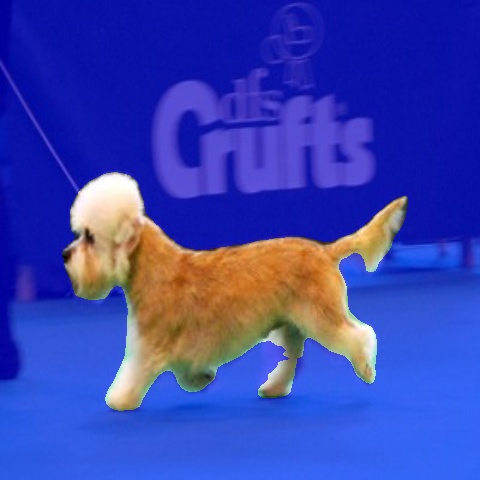


**Image:** ILSVRC2012_test_00000004.jpg  **My reference:** *A golden car parked in grassland*
>>> mask container type: <class 'torch.Tensor'>, shape: (1, 2, 480, 480)


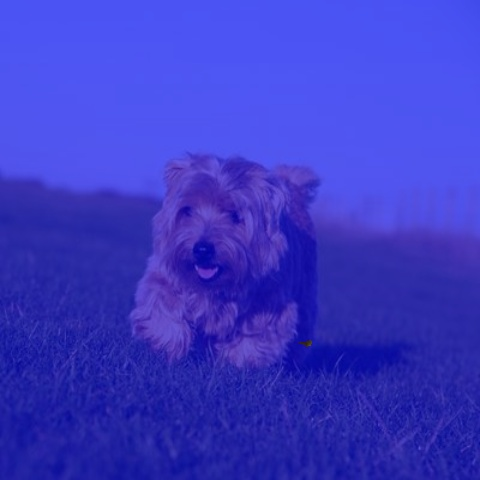


**Image:** ILSVRC2012_test_00000018.jpg  **My reference:** *A group of people playing football*
>>> mask container type: <class 'torch.Tensor'>, shape: (1, 2, 480, 480)


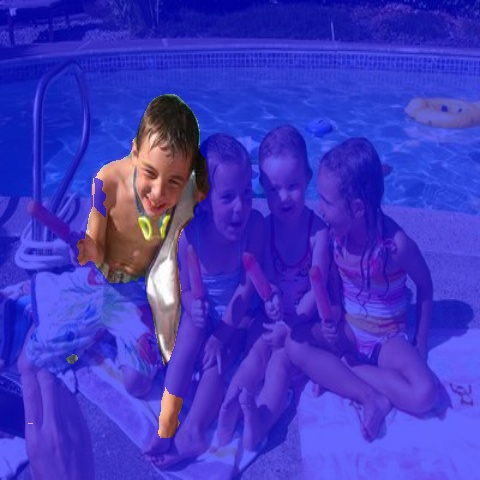


**Image:** ILSVRC2012_test_00000019.jpg  **My reference:** *A dog running in the park*
>>> mask container type: <class 'torch.Tensor'>, shape: (1, 2, 480, 480)


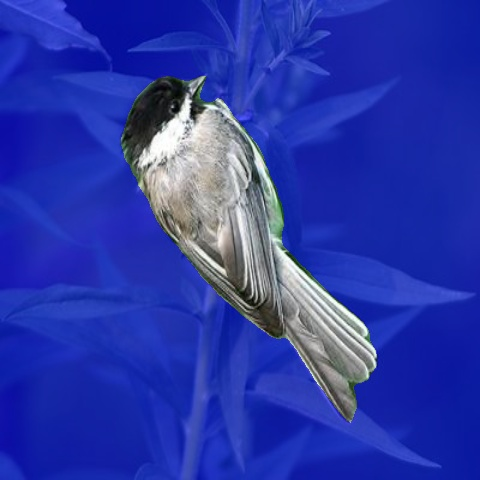


**Image:** ILSVRC2012_test_00000022.jpg  **My reference:** *A boat sailing on the ocean*
>>> mask container type: <class 'torch.Tensor'>, shape: (1, 2, 480, 480)


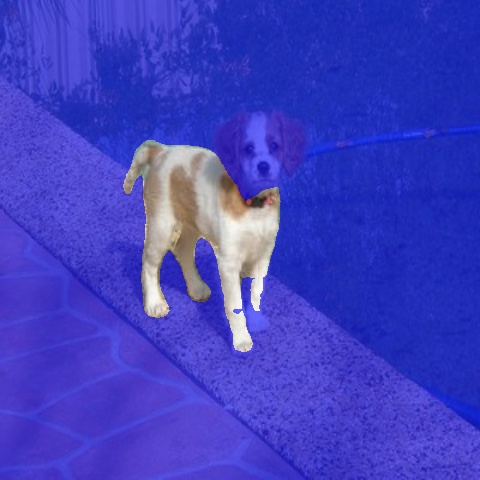


**Image:** ILSVRC2012_test_00000023.jpg  **My reference:** *A child painting on a canvas*
>>> mask container type: <class 'torch.Tensor'>, shape: (1, 2, 480, 480)


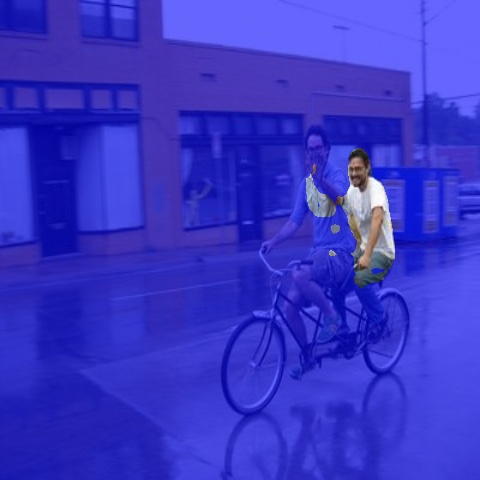


**Image:** ILSVRC2012_test_00000025.jpg  **My reference:** *A person riding a horse*
>>> mask container type: <class 'torch.Tensor'>, shape: (1, 2, 480, 480)


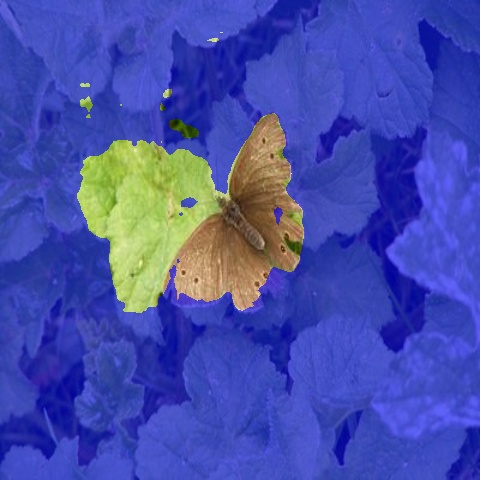


**Image:** ILSVRC2012_test_00000026.jpg  **My reference:** *A man cooking in a kitchen*
>>> mask container type: <class 'torch.Tensor'>, shape: (1, 2, 480, 480)


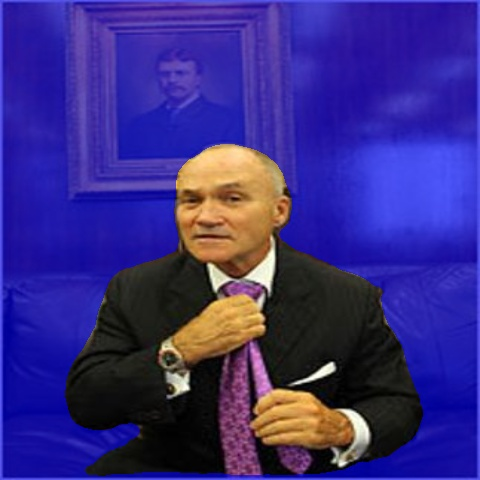


**Image:** ILSVRC2012_test_00000030.jpg  **My reference:** *A car driving down a highway*
>>> mask container type: <class 'torch.Tensor'>, shape: (1, 2, 480, 480)


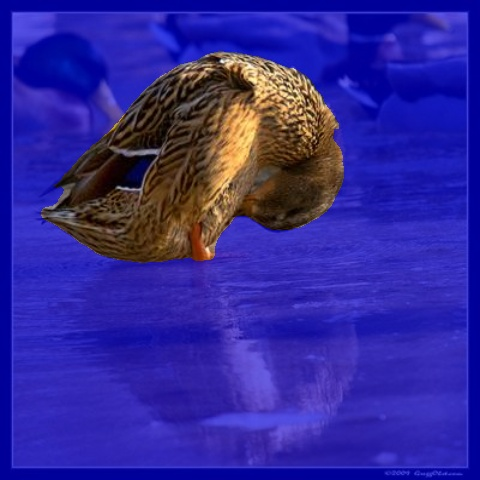


**Image:** ILSVRC2012_test_00000034.jpg  **My reference:** *A row of bicycles lined up*
>>> mask container type: <class 'torch.Tensor'>, shape: (1, 2, 480, 480)


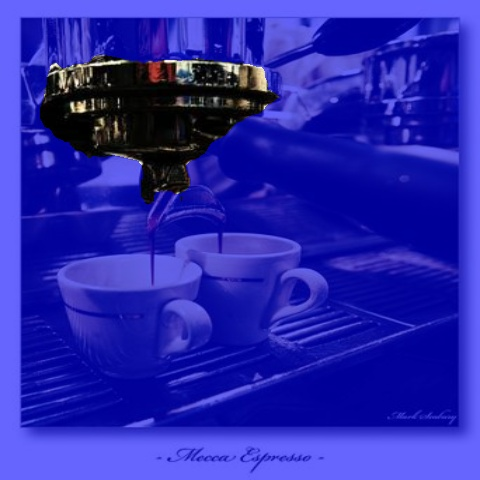

In [ ]:

my_prompts = {
    'ILSVRC2012_test_00000003.jpg': "A cat sleeping on a sofa",
    'ILSVRC2012_test_00000004.jpg': "A golden car parked in grassland",
    'ILSVRC2012_test_00000018.jpg': "A group of people playing football",
    'ILSVRC2012_test_00000019.jpg': "A dog running in the park",
    'ILSVRC2012_test_00000022.jpg': "A boat sailing on the ocean",
    'ILSVRC2012_test_00000023.jpg': "A child painting on a canvas",
    'ILSVRC2012_test_00000025.jpg': "A person riding a horse",
    'ILSVRC2012_test_00000026.jpg': "A man cooking in a kitchen",
    'ILSVRC2012_test_00000030.jpg': "A car driving down a highway",
    'ILSVRC2012_test_00000034.jpg': "A row of bicycles lined up"
}

from IPython.display import display, Markdown, Image as IPImage

for fname, my_ref in my_prompts.items():
    tag = fname.split('.')[0] + '_MYFAIL'
    print(f"\n**Image:** {fname}  **My reference:** *{my_ref}*")
    run_one(os.path.join(SAMPLES_DIR, fname), my_ref, tag)
    
    display(IPImage(f"{OUT_DIR}/{tag}_overlay.jpg", width=320))
